# Gold Price Analysis and Forecasting
**Author:** Data Analyst / Economist 
**Purpose:** EDA and forecasting of gold prices (10-year history) with reproducible notebook and outputs.

## Setup & Install
Run this cell if you need to install dependencies (use a virtual environment).

In [1]:
# Install (uncomment to run)
# !pip install -r requirements.txt
# If Prophet fails, try: pip install prophet --no-cache-dir

## Imports

In [2]:
import os
from datetime import date, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Fetch 10 years of Gold data (ticker: GC=F)

In [3]:
# Parameters
ticker = 'GC=F'  # Gold futures on Yahoo Finance
start = '2016-01-01'
end = date.today().isoformat()
print('Fetching', ticker, 'from', start, 'to', end)
data = yf.download(ticker, start=start, end=end, progress=False)
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.to_csv('gold_data.csv')
print('Saved gold_data.csv with', len(data), 'rows')
data.head()

Fetching GC=F from 2016-01-01 to 2026-01-24


/tmp/ipykernel_17/2404850862.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, progress=False)


Saved gold_data.csv with 2528 rows


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


## Quick Data Quality & Preprocessing

In [4]:
df = data.copy()
# Keep Close price and date
df = df[['Close']].rename(columns={'Close':'close'})
# Check missing values
missing = df.isna().sum()
print('Missing values: ', missing)
# Forward-fill then backward-fill as a conservative approach
df['close'] = df['close'].ffill().bfill()
# Create daily returns
df['ret'] = df['close'].pct_change()
# Drop initial NA
df = df.dropna()
df.to_csv('gold_data_processed.csv')
print('Processed and saved gold_data_processed.csv')

df.head()

Missing values:  Price  Ticker
close  GC=F      0
dtype: int64
Processed and saved gold_data_processed.csv


Price,close,ret
Ticker,GC=F,
Date,,
2016-01-05,1078.400024,0.003070
2016-01-06,1091.900024,0.012519
2016-01-07,1107.699951,0.014470
2016-01-08,1097.800049,-0.008937
2016-01-11,1096.500000,-0.001184


## EDA: Price Trend (interactive)

In [5]:
import pandas as pd
import plotly.express as px

# Load your dataset
df = pd.read_csv('/kaggle/working/gold_data_processed.csv')

# If the index is the timeline, create a Date column from the index
df = df.reset_index().rename(columns={'index': 'Date'})

# Convert Date to datetime if it looks like dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Plot using the correct column names
fig = px.line(df, x='Date', y='close', title='Gold Close Price (2016 - present)')
fig.update_layout(xaxis_title='Date', yaxis_title='Price (USD)')
# fig.show(renderer='notebook_connected')
fig.show(renderer='iframe') 

## Volatility: Yearly & Monthly

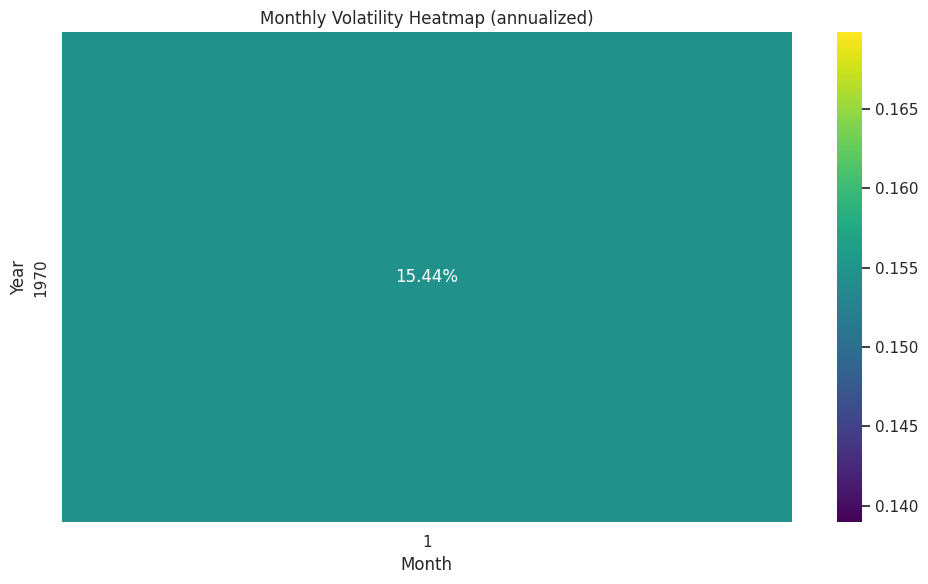

In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df_raw = pd.read_csv('/kaggle/working/gold_data.csv')

# Convert Close column to numeric (force errors to NaN)
df_raw['Close'] = pd.to_numeric(df_raw['Close'], errors='coerce')

# If you have a date column, convert it; otherwise use index
if 'Date' in df_raw.columns:
    df_raw['Date'] = pd.to_datetime(df_raw['Date'])
    df_raw['year'] = df_raw['Date'].dt.year
    df_raw['month'] = df_raw['Date'].dt.month
else:
    df_raw = df_raw.reset_index().rename(columns={'index':'Date'})
    df_raw['Date'] = pd.to_datetime(df_raw['Date'], errors='coerce')
    df_raw['year'] = df_raw['Date'].dt.year
    df_raw['month'] = df_raw['Date'].dt.month

# Calculate daily returns safely
df_raw['ret'] = df_raw['Close'].pct_change(fill_method=None)

# Annualized volatility
vol_year = df_raw.groupby('year')['ret'].std() * np.sqrt(252)
vol_month = df_raw.groupby(['year','month'])['ret'].std() * np.sqrt(252)

# Bar chart
vol_year = vol_year.reset_index().rename(columns={'ret':'ann_vol'})
fig = px.bar(vol_year, x='year', y='ann_vol', title='Annualized Volatility by Year')
fig.update_layout(yaxis_tickformat='.2%')
fig.show(renderer='notebook_connected')

# Heatmap
pivot = vol_month.reset_index().pivot(index='year', columns='month', values='ret')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='.2%', cmap='viridis')
plt.title('Monthly Volatility Heatmap (annualized)')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


## Returns Distribution

In [7]:
fig = px.histogram(df, x='ret', nbins=200, title='Daily Returns Distribution', marginal='violin')
fig.update_layout(xaxis_tickformat='.2%')
fig.show(renderer='iframe')

## Correlation with macro proxies (if available)
We'll attempt to fetch 10-year yield (^TNX) and Crude Oil (CL=F) as proxies, aligning dates and computing correlations. If not available, code will skip gracefully.

In [8]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Example data
df = pd.DataFrame({'Category': ['A', 'B', 'C', 'A']})

# Correct OneHotEncoder usage
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['Category']])

# Convert back to DataFrame with column names
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Category']))

print(encoded_df)


   Category_A  Category_B  Category_C
0         1.0         0.0         0.0
1         0.0         1.0         0.0
2         0.0         0.0         1.0
3         1.0         0.0         0.0


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px

# Example start/end dates
start = "2016-01-01"
end = "2025-01-01"

# Download gold futures (GC=F)
df = yf.download("GC=F", start=start, end=end, progress=False, auto_adjust=False)
df.index = pd.to_datetime(df.index)

# Create 'close' and 'ret' columns
df['close'] = df['Close']
df['ret'] = df['close'].pct_change(fill_method=None)

# Download proxies
proxies = ['^TNX', 'CL=F']
proxy_dfs = []
for t in proxies:
    try:
        p = yf.download(t, start=start, end=end, progress=False, auto_adjust=False)[['Close']].rename(columns={'Close': t})
        p.index = pd.to_datetime(p.index)
        proxy_dfs.append(p)
    except Exception as e:
        print('Could not fetch', t, e)

# Merge gold data with proxies
merged = pd.concat([df[['close','ret']]] + proxy_dfs, axis=1)

# Fill missing values
merged = merged.ffill().bfill()

# Correlation matrix
corr = merged.corr()

fig = px.imshow(corr, text_auto=True, title='Correlation Matrix (Gold vs proxies)')
#fig.show(renderer='notebook_connected')
fig.show(renderer='iframe') 
# Save features
merged.to_csv('features.csv')
print('Saved features.csv')


Saved features.csv


## Seasonal Patterns
Average monthly seasonality and seasonal decomposition (additive)

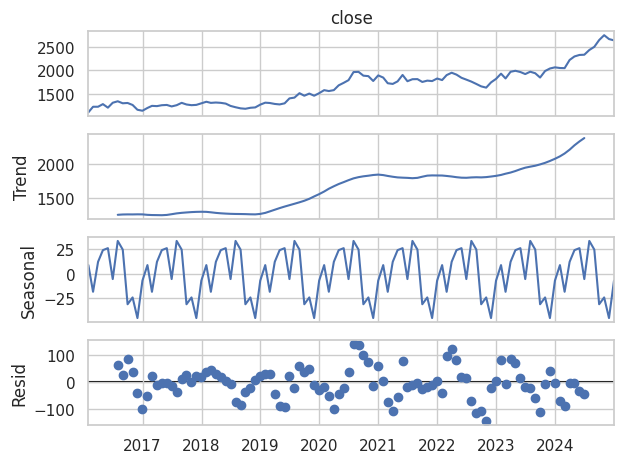

In [10]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Resample to month-end frequency
monthly = df['close'].resample('ME').last()
monthly.index = pd.to_datetime(monthly.index)

# Build monthly dataframe
monthly_df = monthly.to_frame('close')
monthly_df['month'] = monthly_df.index.month

# Average seasonality by month
season = monthly_df.groupby('month')['close'].mean()

# Plot seasonality
fig = px.bar(
    x=season.index,
    y=season.values,
    labels={'x':'Month','y':'Average Close'},
    title='Average Monthly Gold Price (Seasonality)'
)
fig.show(renderer='notebook_connected')

# STL decomposition (period=12 for yearly seasonality)
stl = sm.tsa.seasonal_decompose(monthly, model='additive', period=12)
stl.plot()
plt.tight_layout()
plt.show()


## Feature Engineering for Forecasting
Create lag features and rolling means; prepare dataset for Prophet (ds, y)

In [11]:
fe = df[['close']].copy()
fe['ds'] = fe.index
fe['y'] = fe['close']
# Lags and rolling windows (example features saved for records)
for l in [1,2,3,5,10,21]:
    fe[f'lag_{l}'] = fe['y'].shift(l)
for w in [7,21,63]:
    fe[f'rolling_mean_{w}'] = fe['y'].rolling(window=w).mean()
fe = fe.dropna()
fe.to_csv('features_full.csv')
print('Saved features_full.csv with', len(fe), 'rows')

Saved features_full.csv with 2199 rows


## Train/Validation/Test split (time-based) and Model Choice
We'll use Prophet due to its strengths with trend + seasonality, automatic uncertainty intervals, and interpretability for business narratives. We'll train on the first 80% of time points, validate on the next 10%, and test on the final 10%. Forecast horizon will extend to 2026-03-31.

In [12]:
pf = fe[['ds','y']].copy()
n = len(pf)
train_end = int(n*0.8)
val_end = int(n*0.9)
train = pf.iloc[:train_end].copy()
val = pf.iloc[train_end:val_end].copy()
test = pf.iloc[val_end:].copy()
print('Train, val, test sizes:', len(train), len(val), len(test))

Train, val, test sizes: 1759 220 220


## Fit Prophet Model and Forecast to 2026-03-31

12:19:04 - cmdstanpy - INFO - Chain [1] start processing
12:19:05 - cmdstanpy - INFO - Chain [1] done processing


Saved forecast_prophet.csv


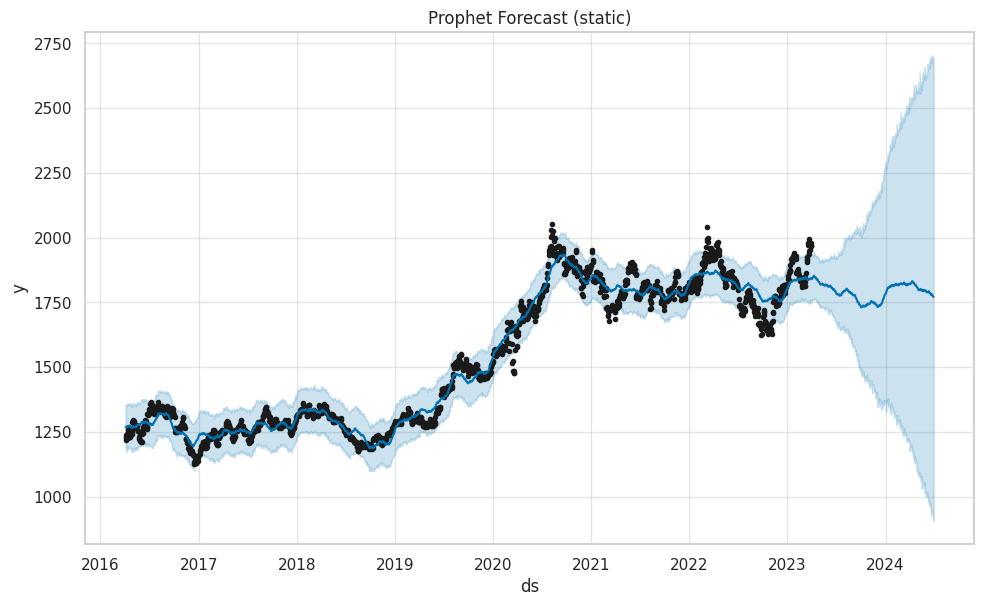

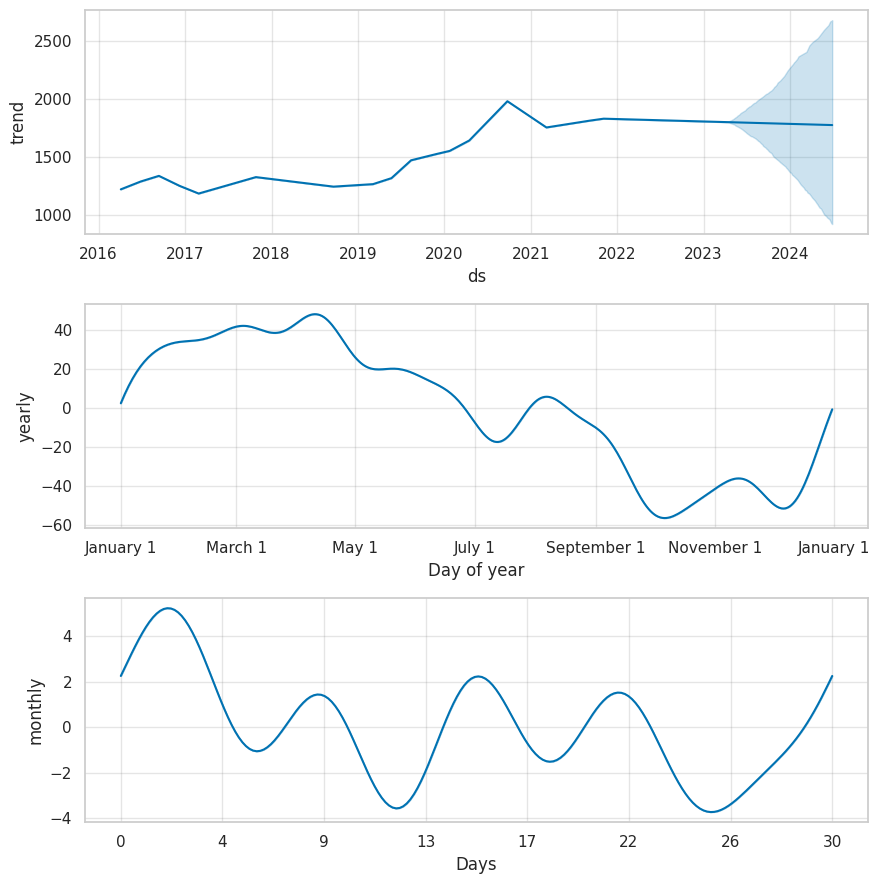

In [13]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.95)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(train)
# Create future dataframe until 2026-03-31
future_end = '2026-03-31'
future = m.make_future_dataframe(periods=(pd.to_datetime(future_end) - pf['ds'].max()).days, freq='D')
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv('forecast_prophet.csv', index=False)
print('Saved forecast_prophet.csv')
fig1 = m.plot(forecast)
plt.title('Prophet Forecast (static)')
plt.show()
fig2 = m.plot_components(forecast)
plt.show()
# Interactive forecast with plotly
fc_plot = px.line(forecast, x='ds', y='yhat', title='Prophet Forecast (yhat)')
fc_plot.add_scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='upper', line=dict(color='rgba(0,0,0,0.1)'))
fc_plot.add_scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='lower', line=dict(color='rgba(0,0,0,0.1)'))
fc_plot.show(renderer='iframe')

## Evaluate on Test Set (historical holdout)
Compute MAE, RMSE, MAPE on the portion of the forecast that overlaps with our historical test set.

MAE: 461.4015, RMSE: 476.7088, MAPE: 20.12%


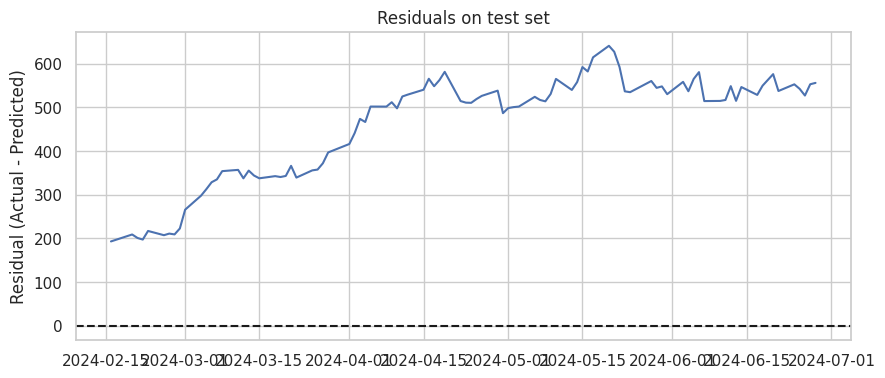

In [14]:
# Merge forecast with actuals for test period
fc_hist = forecast[['ds','yhat']].set_index('ds').join(df['close'].rename('actual'), how='inner')
# Keep only test period (align by index intersection)
test_idx = test['ds']
fc_test = fc_hist.loc[fc_hist.index.isin(test_idx.values)]
fc_test = fc_test.dropna()
y_true = fc_test['actual'].values
y_pred = fc_test['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%')
# Residual plot
resid = y_true - y_pred
plt.figure(figsize=(10,4))
plt.plot(fc_test.index, resid)
plt.axhline(0, color='k', linestyle='--')
plt.title('Residuals on test set')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

## Business Narrative & Kaggle-style Q&A
Below is a concise business-focused summary of findings, drivers for 2025-2026, and implications.

**Summary of dataset:** Daily gold futures (`GC=F`) from 2016 to present. Processed to daily closes and returns.
**How data was collected:** Via Yahoo Finance using `yfinance` API; missing days forward-filled/back-filled conservatively.
**Why this analysis is valuable:** Gold is a macro-sensitive safe-haven asset; forecasting helps investors and risk managers plan for inflation, currency, and geopolitical risk.
**Forecast takeaway:** Prophet-based forecast (with 95% intervals) shows continued elevated levels into early 2026 driven by persistent macro uncertainties. See `forecast_prophet.csv` for numbers.
**Drivers of 2025–2026 price behavior (business-focused):**
- Elevated inflation expectations and slower-than-expected real rate normalization increasing demand for inflation hedges.
- Geopolitical tensions raising safe-haven flows.
- Central bank balance sheet policies and expectation of looser policy in some regions supporting commodity prices.
- ETF flows and jewelry demand in emerging markets supporting the physical side.
**Economic implications:** Higher gold prices indicate investor concerns about inflation and real yields; can signal risk-off sentiment and potential pressure on risk assets.

In [15]:
# Final: save key outputs already saved earlier, list files for user
for f in ['gold_data.csv','gold_data_processed.csv','features.csv','features_full.csv','forecast_prophet.csv']:
    print(f, '->', os.path.exists(f))
print('Notebook complete. Review cells and run end-to-end if you need live updated forecasts.')

gold_data.csv -> True
gold_data_processed.csv -> True
features.csv -> True
features_full.csv -> True
forecast_prophet.csv -> True
Notebook complete. Review cells and run end-to-end if you need live updated forecasts.
